# Beating the DeepFood paper

Using Transfer Learning (EfficientNetB0), fine tuning, and mixed precision I am going to build a CNN with a validation accuracy higher than 77%.

## Get helper functions


In [1]:
# Eventually going to upload to GitHub, but they are currently stored locally
from google.colab import files

uploaded = files.upload()

Saving NN_felpers.py to NN_felpers.py


In [2]:
# For uploading from Github

"""
!wget githublink
"""

'\n!wget githublink\n'

In [3]:
# importing all the functions, may not use all of them
from NN_felpers import import_prep_image, pred_plus_plot, make_callback_TB, unzip_folder, compare_historys, loss_plot, break_down_dir, create_confusion_matrix

## Using TensorFlow Datasets to Download food101

In [4]:
# Get TensorFlow Dataset
import tensorflow_datasets as tfds

In [ ]:
# Load in Data (use High-Ram runtime to ensure import)
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, # data gets returned in Tuple format (data, label)
                                             with_info = True) # for ds_info variable

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [6]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Look at shape of data
example_img = train_data.take(1) # takes 1 sample from the data, format is (image_tensor, label)
example_img

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10] # first 10

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Info about example image
for image, label in example_img:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str): {class_names[label.numpy()]}
""")



  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str): cheesecake



## Preprocess

What needs to happen:
- uint8 dtype changed to float16 and float32 for mixed precision
- Reshape all images to be the same size
- Don't need to normalize due to the model used

In [10]:
# Make a function for preprocessing images
import tensorflow as tf

def preprocess_img(image, label, img_shape = 224):
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape the target image
  return tf.cast(image, tf.float32), label # return new image and the label in tuple form


In [11]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]..., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and Prepare data

Going to make the data pipeline run fast

In [12]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) # autotune uses as much processing power as is available, multiple chips etc.

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

^ Map this preprocessing function (preprocess_img) across our dataset, then shuffle a number of elements and then batch them together, and then finallly make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) in the current batch

In [13]:
# check type
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create Callbacks

Going to use ModelCheckpoint, TensorBoard, and EarlyStopping

In [14]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 3, # will wait 3 epochs for improvement
                                                  mode = "min", # min val_loss
                                                  verbose = 1) # displays message when stops

# TensorBoardd already imported with make_callback_TB

# Create modelcheckpoint callback to save a model's progresss
checkpoint_path = "model_checkpoints/checkpoint.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor = "val_accuracy",
                                                     save_best_only = True,
                                                     save_weights_only = True,
                                                     verbose = 0)


## Setup Mixed Precision

In [15]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [16]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build base model

In [17]:
from tensorflow.keras import layers

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = (224, 224, 3),
                     name = "input_layer")
# has reshaping built in so we dont need to augment
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)


# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
# Check Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Check layer dtype to see mixed precision

- layer.name : human readable name
- layer.trainable : is the layer trainable or not
- layer.dtype : is the datatype a layer stores its variables in
- layer.dtype_policy : the data type policy a layer computes on its variables with

In [19]:
# Looking for difference between dtype and dtype_policy
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


## Fit Feature Extraction Model

In [20]:
# Fit model with callbacks
history_feature_extraction = model.fit(train_data,
                                       epochs = 10,
                                       validation_data = test_data,
                                       #validation_steps = int(0.30 * len(test_data)), #validate on 30% of test_data
                                       callbacks = [make_callback_TB(log_dir = "training_montage",
                                                                     experiment_name = "efficientnetB0_feature_extract_10_epochs"),
                                                    model_checkpoint
                                                    # early_stopping # not needed yet
                                                    ])

Saving TensorBoard log files to: training_montage/efficientnetB0_feature_extract_10_epochs/20241122-011611
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 130s 44ms/step - accuracy: 0.4340 - loss: 2.4563 - val_accuracy: 0.6549 - val_loss: 1.3121
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.6295 - loss: 1.4522 - val_accuracy: 0.6817 - val_loss: 1.1925
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.6666 - loss: 1.2907 - val_accuracy: 0.6921 - val_loss: 1.1460
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.6887 - loss: 1.1888 - val_accuracy: 0.6942 - val_loss: 1.1263
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.7033 - loss: 1.1256 - val_accuracy: 0.6998 - val_loss: 1.1099
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.7193 - loss: 1.0616 - val_accuracy: 0.6992 - val_loss: 1.1070
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.7311 - loss: 1.0153 - val_accu

In [21]:
feature_extract_epoch_10_eval = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6953 - loss: 1.1282


In [22]:
feature_extract_epoch_10_eval

[1.1198567152023315, 0.699326753616333]

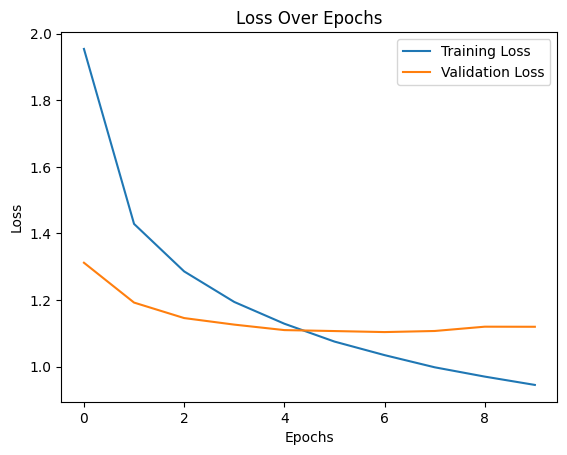

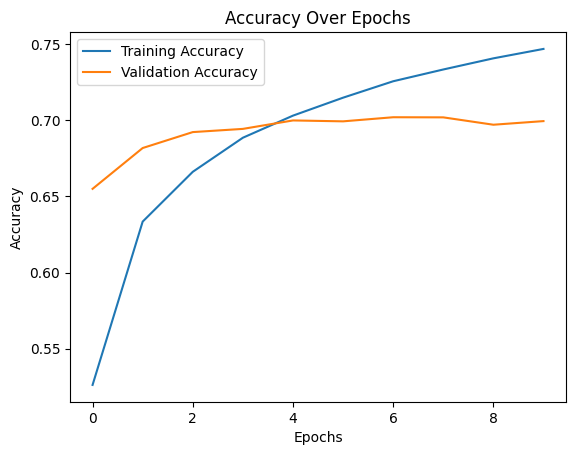

In [23]:
# Check plot
loss_plot(history_feature_extraction)

Model started overfitting at about epoch 4, however the highest val_accuracy was epoch 7 so that was saved

### Save file


In [24]:
# Save model locally, then download
model.save("efficientnetB0_mixed_precision_feature_extract_10_epochs.keras")

### Load in checkpointed weight


In [25]:
# Make function to be able to make new model then add the saved weights
def make_model():

  #make base model
  base_model = tf.keras.applications.EfficientNetB0(include_top = False)
  base_model.trainable = False

  # make working model
  inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
  x = base_model(inputs, training = False)
  x = layers.GlobalAveragePooling2D(name = "GAP2D")(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
  new_model = tf.keras.Model(inputs, outputs)

  return new_model



In [26]:
# Create + Compile
model_2 = make_model()

model_2.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [27]:
# Load the saved weights
model_2.load_weights(checkpoint_path)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
# Evalute with the loaded weights
model_2_eval_pre_fine_tune = model_2.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6968 - loss: 1.1079


In [29]:
model_2_eval_pre_fine_tune[1]

0.700316846370697

In [30]:
# comparing non-loaded vs loaded
print(f"Non-Loaded val_acc: {feature_extract_epoch_10_eval[1]}") # Epoch 10
print(f"Loaded val_acc: {model_2_eval_pre_fine_tune[1]}") #Ended up on the same epoch (lower epoch)

Non-Loaded val_acc: 0.699326753616333
Loaded val_acc: 0.700316846370697


## Fine Tune


In [31]:
# Set to trainable and check for mixed precision
for layer in model_2.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 True float32 <DTypePolicy "mixed_float16">
GAP2D True float32 <DTypePolicy "mixed_float16">
dense_1 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [43]:
# Check which layers are trainable should be all of them
for i, layer in enumerate(model_2.layers[1].layers):
  if i >= 20:
    break
  print(i, layer.name, layer.trainable)

0 input_layer_1 True
1 rescaling_2 True
2 normalization_1 True
3 rescaling_3 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True


### Add new callback

Add a new callback reducing the learning rate after 2 epochs of no improvement

In [33]:
# new callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                 factor = 0.2, # reduce by 5 times every time
                                                 patience = 2, # will reduce after 2 epochs of no improvement
                                                 verbose = 1, # print when learning rate changes
                                                 min_lr = 1e-7) # min learning rate

In [34]:
# Change checkpoint to have new weights file
checkpoint_path = "model_checkpoints/checkpoint_fine_tuned.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor = "val_accuracy",
                                                     save_best_only = True,
                                                     save_weights_only = True,
                                                     verbose = 0)

### Recompile

In [35]:
# Recompile the model
model_2.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["accuracy"])


### Fit (again)

In [36]:
# Fine tuned model fit
history_fine_tune = model_2.fit(train_data,
                                epochs = 100,
                                validation_data = test_data,
                                validation_steps = int(0.30 * len(test_data)),
                                callbacks = [make_callback_TB(log_dir = "training_montage",
                                                              experiment_name = "efficientnetB0_fine_tuned"),
                                            model_checkpoint,
                                            early_stopping,
                                            reduce_lr])


Saving TensorBoard log files to: training_montage/efficientnetB0_fine_tuned/20241122-013209
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 332s 103ms/step - accuracy: 0.6044 - loss: 1.5355 - val_accuracy: 0.7831 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - accuracy: 0.7986 - loss: 0.7359 - val_accuracy: 0.8099 - val_loss: 0.6746 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - accuracy: 0.8629 - loss: 0.5036 - val_accuracy: 0.8109 - val_loss: 0.7007 - learning_rate: 1.0000e-04
Epoch 4/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9036 - loss: 0.3523
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - accuracy: 0.9036 - loss: 0.3523 - val_accuracy: 0.7982 - val_loss: 0.7228 - learning_rate: 1.0000e-04
Epoch 5/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - accuracy: 0.9461 - loss: 0.2204 - val_accuracy: 0.8241 - val_loss: 0.6558 - learning_rate: 2.0000e-05
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - accuracy: 0.9571 - loss: 0.1808 - val_accuracy: 0.8289 - val_loss: 0.6346 - learning_rate: 2.0000e-05
Epoch 7/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - accuracy: 0.9645 - loss: 0.1557 - val_accuracy: 0.8257 - val_loss: 0.6681 - learning_rate: 2.0000e-05
Epoch 8/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9718 - loss: 0.1338
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 191s 80ms/step - accuracy: 0.9718 - loss: 0.1338 - val_accuracy: 0.8114 - val_loss: 0.6855 - learning_rate: 2.0000e-05
Epoch 9/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 193s 81ms/step - accuracy: 0.9757 - loss: 0.1186 - val_accuracy: 0.8271 - val_loss: 0.6641 - learning_rate: 4.0000e-06
Epoch 9: early stopping


In [41]:
model_2.save("efficientnetB0_mixed_precision_fine_tuned.keras")

## Visualize

In [38]:
# Not bad not bad not bad
print(f"Validation accuracy: {model_2.evaluate(test_data)[1]*100:.2f}%")

790/790 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.8283 - loss: 0.6573
Validation accuracy: 82.57%


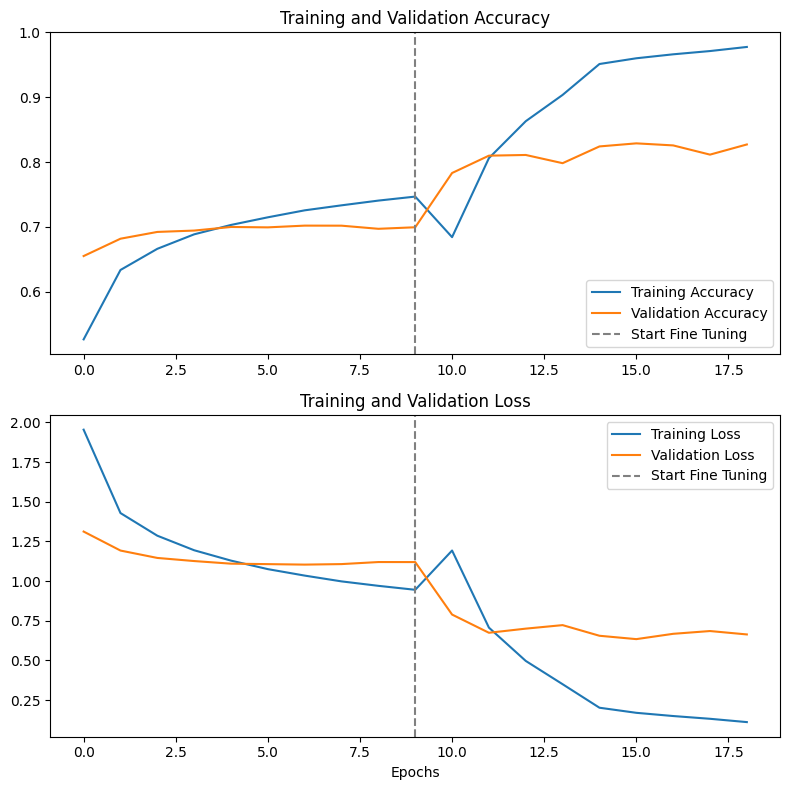

In [39]:
compare_historys(original_history = history_feature_extraction,
                 new_history = history_fine_tune,
                 initial_epochs = 10)

## Conclusion

Not bad at all. The model finished with a test accuracy of 97.57% and a verification accuracy of 82.57% which beats the [DeepFood's](https://arxiv.org/pdf/1606.05675) accuracy of 77.4%.


I do think there is opertunity to do better though. Maybe by unfreezing the layers in groups instead of all at once, or maybe by using a higher level efficientnet model, I guess we will just have to find out...